## Todo
- metric
- cross evaluation
- hyper parameter grid search


In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Import

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn import model_selection

%load_ext autoreload
%autoreload 2
from mypkg.football_ml_dataset import Feature
from mypkg.football_ml_dataset import MatchStatsDataset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
The data is loaded into MatchStatsDataset objects with data from one season in each. The first 30 matches in each season are dropped because some history is needed to make predictions. Results from last season is considered inadequate.

In [17]:
path ='./Data/'
# not used for now 'PL0001.csv', 'PL0102.csv', 'PL0203.csv', 'PL0304.csv', 'PL0405.csv',
files = ['PL0506.csv', 'PL0607.csv', 'PL0708.csv', 'PL0809.csv', 'PL0910.csv',
         'PL1011.csv', 'PL1112.csv', 'PL1213.csv','PL1314.csv', 'PL1415.csv',
         'PL1516.csv', 'PL1617.csv', 'PL1718.csv']
datasets = []
print('Read csv and initialize MatchStatsDataset objects...')
for file in files:
    try:
        df = pd.read_csv(path+file)
        datasets.append(MatchStatsDataset(df, 30))
    except:
        print('pd.read_csv failed for :' + path+file)

print('Finished! '+ str(len(datasets))+ ' season datasets loaded.')

Read csv and initialize MatchStatsDataset objects...
Finished! 13 season datasets loaded.


## Calc features
Features are calculated from past games.
The dictionary dct_features is creating Feature objects (from football_ml_dataset), that defines which features to calculate.

In [18]:
dct_features = {'ht_prcwin_prev5_homegames':Feature('H', 'prcwin', 5, 'H'),
            'at_prcwin_prev5_awaygames':Feature('A', 'prcwin', 5, 'A'),
            #'ht_goalsscored_prev5_homegames':Feature('H', 'goalsscored', 5, 'H'),
            #'at_goalsscored_prev5_awaygames':Feature('A', 'goalsscored', 5, 'A'),
            'ht_goalsagainst_prev5_homegames':Feature('H', 'goalsagainst', 5, 'H'),
            'at_goalsagainst_prev5_awaygames':Feature('A', 'goalsagainst',5, 'A'),
            'ht_goalsscoredewma_prev20_homegames':Feature('H', 'goalsscoredewma', 20, 'H'),
            'at_goalsscoredewma_prev20_awaygames':Feature('A', 'goalsscoredewma', 20, 'A'),
            }

#Calc features and aggregate match data into one dataframe
#The final dataframe contains both features and other match data (like FTR)
print('Calculating features ...')
df = pd.DataFrame()
for i, ds in enumerate(datasets):
    dftmp = ds.get_features_and_matchdata(dct_features)
    df = dftmp if df.empty else df.append(dftmp)

#Do various postprocessing
df.index = range(df.shape[0])
for col in dct_features:
    df[col] = pd.to_numeric(df[col])
df = df[df.FTR.notnull()]
df = df.dropna()

print('Finished!')

Calculating features ...
Finished!


## Explore data
We are looking for feature differences for the result categories. That would make the feature a potential useful variable in the machine learning algorithm

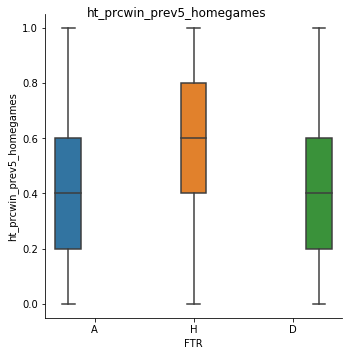

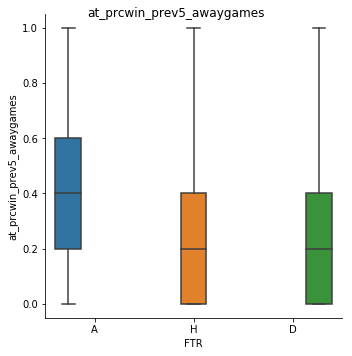

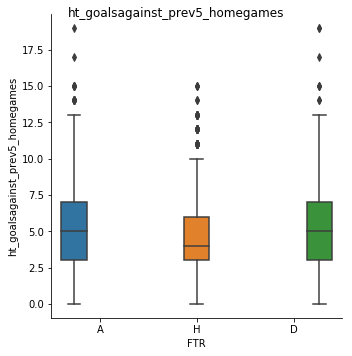

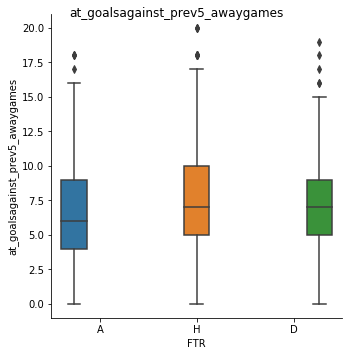

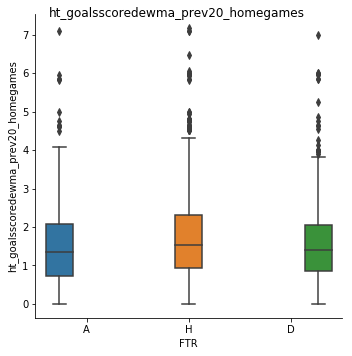

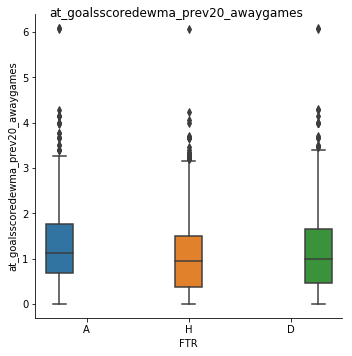

In [19]:
for feature in dct_features:
    #ax = sns.distplot(df[feature])
    #plt.show()
    g = sns.catplot(x='FTR', y=feature, hue='FTR', data=df, kind="box", row_order=['H', 'D', 'A'])
    g.fig.suptitle(feature) 
    

Since there is a lot of overlap between the categories and since I am more interested in the probabilities than the actual predicted classification, I will make random samples from the dataset and plot the features against the probability of each outcome.

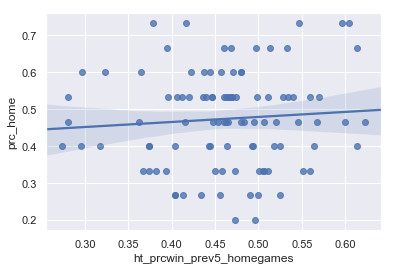

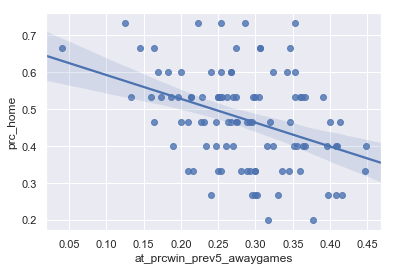

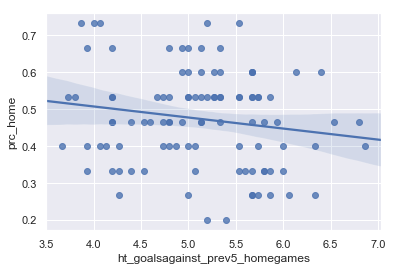

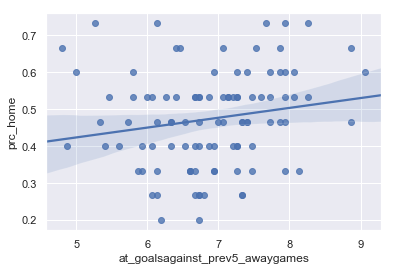

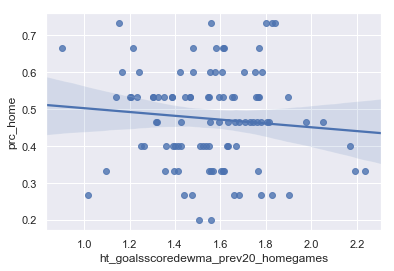

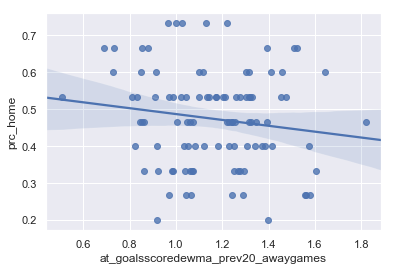

In [30]:
columns = list(dct_features.keys())  + ['prc_home', 'prc_draw', 'prc_away']
df_samples = pd.DataFrame(columns = columns, dtype = float)

for i in range(100):
    sample = df.sample(n=15, random_state=i)
    df_samples.loc[i,:] = sample.mean()
    FTR_count = sample.FTR.value_counts()
    df_samples.loc[i,'prc_home'] = (FTR_count['H']/sample.shape[0]) if 'H' in FTR_count else 0
    df_samples.loc[i,'prc_draw'] = (FTR_count['D']/sample.shape[0]) if 'D' in FTR_count else 0
    df_samples.loc[i,'prc_away'] = (FTR_count['A']/sample.shape[0]) if 'A' in FTR_count else 0
    
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.set()
for col in dct_features:
    #df_samples.plot.scatter(x=col, y='prc_home')
    sns.regplot(data=df_samples, x=col, y='prc_home')
    plt.show()


## Prepare data: split, transform and scale

In [21]:
#Get features and labels as numpy
features = df[dct_features.keys()].to_numpy()
labels = df.FTR.replace({}).replace({'H':0, 'D':1, 'A':2}).to_numpy()

#Split
indx = range(features.shape[0])
test_size = int(features.shape[0]/10)
indx = model_selection.train_test_split(indx, test_size=test_size)
x_train = features[indx[0],:]
y_train = labels[indx[0]]
x_test = features[indx[1]]
y_test = labels[indx[1]]

#Transform to get features that are closer to normal distributed
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit_transform(x_train)
x_train = pt.transform(x_train)
x_test = pt.transform(x_test)

#Scale
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

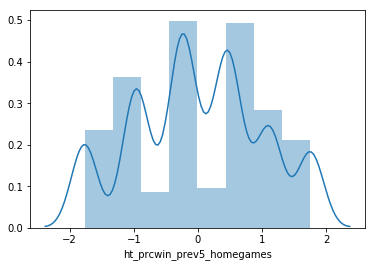

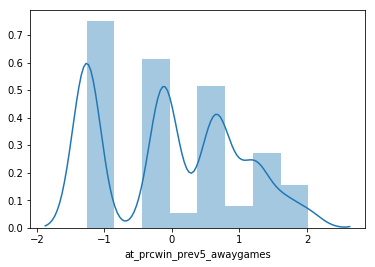

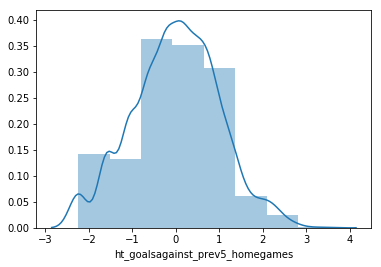

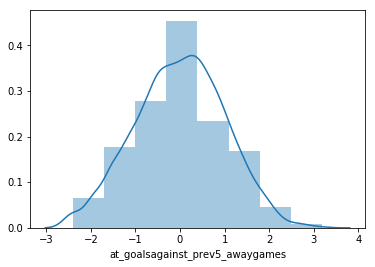

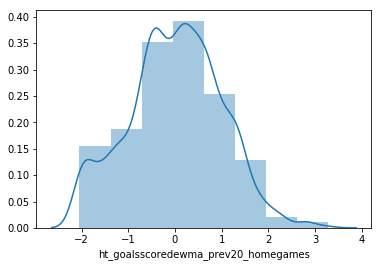

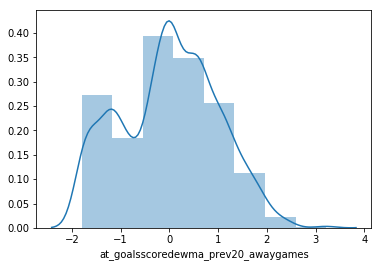

In [22]:
#Plot distributions of transformed and scaled data
df_processed = pd.DataFrame(x_train, columns=list(dct_features.keys()))
for col in df_processed:
    sns.distplot(df_processed[col], bins=8)
    plt.show()

## Fitting models
As a beginning I will use logistic regression and random forest classifier

In [23]:
print('Fitting Models ...')

model_logreg = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial')
model_rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
model_logreg.fit(x_train, y_train)
model_rfc.fit(x_train, y_train)

print('Finished!')

Fitting Models ...
Finished!


## Evaluate model
The interesting evaluation is not exactly how well I can predict match outcomes, but if I can predict better than the bookmakers. The bookmakers p(result) is calculated as 1/odds(result).

In this plot I have devided matches into bins based on predicted probabilities and then calculating how many of these matches ended with the given match outcome.

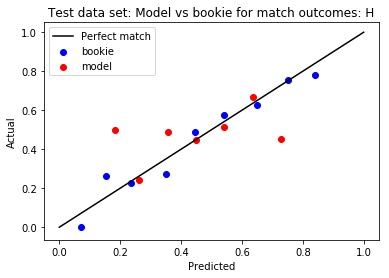

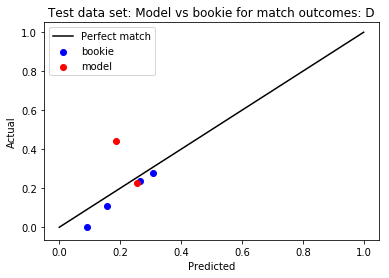

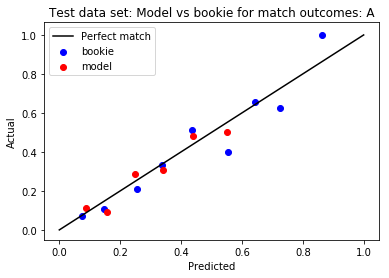

In [26]:
def pred_quality_plot(match_outcome, model, bins=10):

    model_probs = pd.DataFrame(model.predict_proba(x_test), columns = ['p_home', 'p_draw', 'p_away'])
    bookie_probs = df.iloc[indx[1],:]
    bookie_probs.index = range(bookie_probs.shape[0])
    model_probs['FTR'] = bookie_probs['FTR']
    
    p_bins = [x/bins for x in range(bins)]
    
    keymap = {'H':'p_home', 'D':'p_draw', 'A':'p_away'}
    key = keymap[match_outcome]
    
    est_bookie, est_model, act_bookie, act_model = [], [], [], []
    
    for p in p_bins:
        #bookmaker
        df_bookie = bookie_probs[bookie_probs[key] >= p]
        df_bookie = df_bookie[df_bookie[key] < p+1/bins]
        #model
        df_model = model_probs[model_probs[key] >= p]
        df_model = df_model[df_model[key] < p+1/bins]
            
        count_act_b = df_bookie.FTR.value_counts()
        count_act_m = df_model.FTR.value_counts()
            
        est_bookie.append(df_bookie[key].mean())
        est_model.append(df_model[key].mean())
        
        val = count_act_b[match_outcome]/df_bookie.shape[0] if match_outcome in count_act_b.index else 0
        act_bookie.append(val)
        
        val = count_act_m[match_outcome]/df_model.shape[0] if match_outcome in count_act_m.index else 0
        act_model.append(val)
        
    plt.scatter(est_bookie, act_bookie, color='blue', label='bookie')
    plt.scatter(est_model, act_model, color='red', label='model')
    plt.plot([0,1], [0,1], label='Perfect match', color='black')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test data set: Model vs bookie for match outcomes: '+match_outcome)
    plt.legend()
    plt.show()
    
pred_quality_plot('H', model_logreg)
pred_quality_plot('D', model_logreg)
pred_quality_plot('A', model_logreg)

### Trading strategy

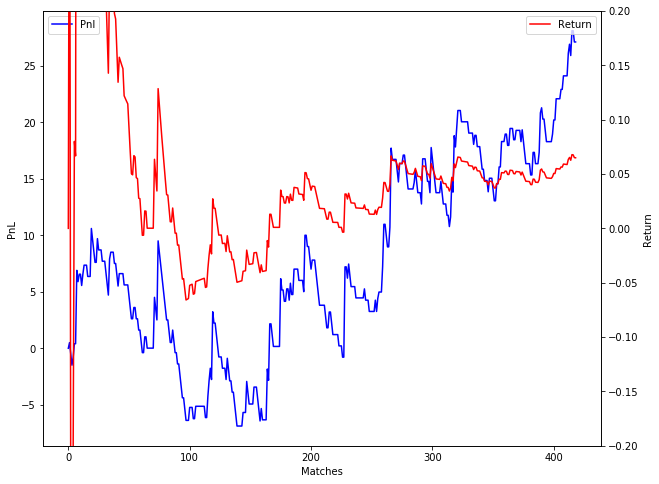

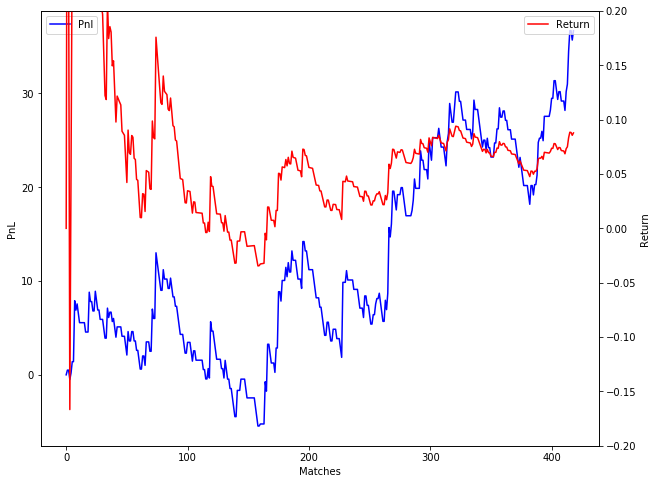

In [25]:
def bet(homedrawaway, amount, odds, ftr):
    if homedrawaway == ftr:
        return amount*(odds-1)
    else:
        return -amount

def trading_strategy(model):

    pnl, total_inv = 0, 0
    pnls, return_rate = [0], [0]
    
    model_probs = pd.DataFrame(model.predict_proba(x_test), columns = ['p_home', 'p_draw', 'p_away'])
    bookie_probs = df.iloc[indx[1],:]
    bookie_probs.index = range(bookie_probs.shape[0])

    for i in range(model_probs.shape[0]):
        p_model_home = model_probs.loc[i, 'p_home']
        p_model_draw = model_probs.loc[i, 'p_draw']
        p_model_away = model_probs.loc[i, 'p_away']
        p_bookie_home = bookie_probs.loc[i, 'p_home']
        p_bookie_draw = bookie_probs.loc[i, 'p_draw']
        p_bookie_away = bookie_probs.loc[i, 'p_away']
        ftr = bookie_probs.loc[i, 'FTR']

        adv_home = p_model_home - p_bookie_home
        adv_draw = p_model_draw - p_bookie_draw
        adv_away = p_model_away - p_bookie_away

        stake = 1
        total_inv += stake

        if adv_home > adv_draw and adv_home > adv_away:
            pnl += bet('H', stake,  1/p_bookie_home, ftr)
        elif adv_draw > adv_home and adv_draw > adv_away:
           pnl += bet('D', stake, 1/p_bookie_draw, ftr)
        elif adv_away > adv_home and adv_away > adv_away:
            pnl += bet('A', stake, 1/p_bookie_away, ftr)

        pnls.append(pnl)
        return_rate.append(pnl/total_inv)

    fig, ax = plt.subplots()
    ax.plot(pnls, color='blue', label='Pnl')
    ax.set_xlabel('Matches')
    ax.set_ylabel('PnL')
    ax2 = ax.twinx()
    ax2.plot(return_rate, color='red', label='Return')
    ax2.set_ylabel('Return')
    fig.set_size_inches(10, 8)
    ax.legend(loc=0)
    ax2.legend(loc=0)
    ax2.set_ylim(-0.2, 0.2)
    plt.show()

trading_strategy(model_logreg)
trading_strategy(model_rfc)
